In [1]:
import h5py
import os

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from tqdm import tqdm

import sys
sys.path.insert(0, "../scripts/")

from statfenics.utils import build_observation_operator
from swe_filter import ShallowOneKalman, ShallowOneEx

fe.set_log_level(50)

In [2]:
def ds_from_output_file(output_file, field="u", var=False):
    checkpoint = h5py.File(output_file, "r")
    nu = checkpoint["/"].attrs["nu"]
    nx = checkpoint["/"].attrs["nx"]
    dt = checkpoint["/"].attrs["dt"]
    k = checkpoint["/"].attrs["k"]
    linear = checkpoint["/"].attrs["linear"]
    
    control = dict(nx=nx, dt=dt, theta=0.6, simulation="immersed_bump")
    params = dict(nu=nu)
    stat_params = dict(rho_u=0., ell_u=0.,
                       rho_h=1., ell_h=1.,
                       hilbert_gp=True, k=1, k_init_u=1, k_init_h=1)
    for key in stat_params:
        stat_params.update({key: checkpoint["/"].attrs[key]})

    if linear:
        swe = ShallowOneKalman(control, params, stat_params, lr=True)
    else:
        swe = ShallowOneEx(control, params, stat_params, lr=True)

    x = swe.x_coords
    t = checkpoint["/t"][:]
    u_mean = checkpoint["/u_mean"][:]
    u_var = checkpoint["/u_var"][:]
    h_mean = checkpoint["/h_mean"][:]
    h_var = checkpoint["/h_var"][:]
    
    u_ds = xr.DataArray(data=u_mean[:, :, np.newaxis, np.newaxis],
                        coords=dict(t=t, x=x.flatten(), nu=np.array([nu]), k=np.array([k])),
                        name="u")
    h_ds = xr.DataArray(data=h_mean[:, :, np.newaxis, np.newaxis],
                        coords=dict(t=t, x=x.flatten(), nu=np.array([nu]), k=np.array([k])),
                        name="h")
    
    u_var_ds = xr.DataArray(data=u_var[:, :, np.newaxis, np.newaxis],
                            coords=dict(t=t, x=x.flatten(), nu=np.array([nu]), k=np.array([k])),
                            name="u_var")
    h_var_ds = xr.DataArray(data=h_var[:, :, np.newaxis, np.newaxis],
                            coords=dict(t=t, x=x.flatten(), nu=np.array([nu]), k=np.array([k])),
                            name="h_var")
    
    return xr.merge([u_ds, h_ds, u_var_ds, h_var_ds])


def errors_from_output_file(output_file, prior=False):
    """ Read in errors from output file. """
    checkpoint = h5py.File(output_file, "r")
    nu = checkpoint["/"].attrs["nu"]
    nt_skip = checkpoint["/"].attrs["nt_skip"]
    k = checkpoint["/"].attrs["k"]
    linear = checkpoint["/"].attrs["linear"]
    
    # just verify we are doing the correct thing
    assert checkpoint["/"].attrs["rho_h"] == 1e-2 
    t_obs = checkpoint["/t_obs"][:]
    rmse = checkpoint["/rmse"][:]
    rmse_ds = xr.DataArray(data=rmse[:, np.newaxis, np.newaxis],
                           coords=dict(t=t_obs, nu=np.array([nu]), nt_skip=np.array([nt_skip])),
                           name="rmse")
    if not prior:
        lml = checkpoint["/lml"][:]
        lml_ds = xr.DataArray(data=lml[:, np.newaxis, np.newaxis],
                              coords=dict(t=t_obs, nu=np.array([nu]), nt_skip=np.array([nt_skip])),
                              name="lml")
        return (nu, nt_skip), xr.merge([rmse_ds, lml_ds])
    else:
        return (nu, nt_skip), rmse_ds

In [3]:
y = xr.open_dataset("../data/h_bump.nc")
y

<xarray.Dataset>
Dimensions:  (t: 30001, x: 501)
Coordinates:
  * t        (t) float64 0.0 0.01 0.02 0.03 0.04 ... 300.0 300.0 300.0 300.0
  * x        (x) float64 0.0 0.05 0.1 0.15 0.2 ... 24.8 24.85 24.9 24.95 25.0
Data variables:
    h        (t, x) float64 ...

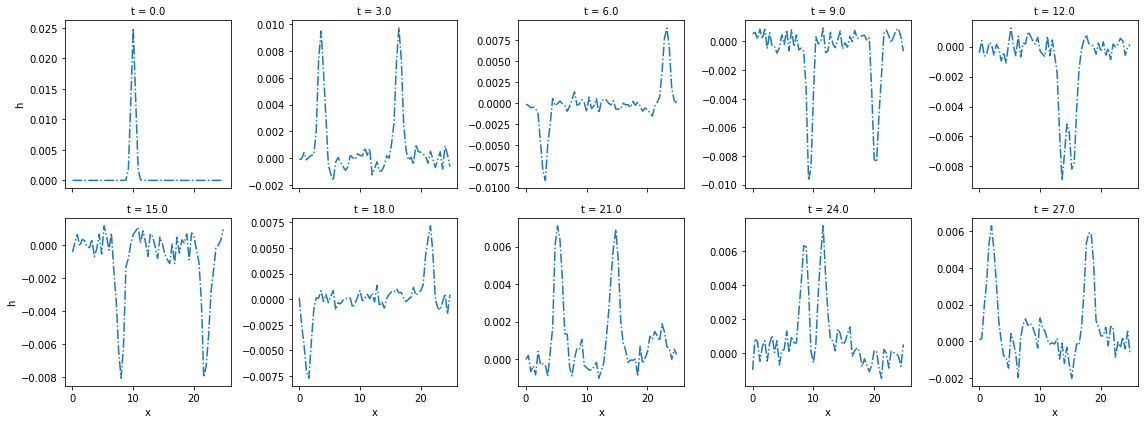

In [4]:
y_obs = y["h"].values[1:, ::8]
y.h.isel(x=slice(0, -1, 8), t=slice(0, 3000, 300)).plot(
    ls="-.", x="x", col="t", col_wrap=5, sharey="none")
plt.show()

In [5]:
from glob import glob
linear_output_files = glob(
    "../outputs/swe-bump/linear-posterior-nt_skip-*.h5")

params = []
state_ds = []
errors_ds = []
for output_file in linear_output_files:
    (nu, nt_skip), e = errors_from_output_file(output_file)
    params.append((nu, nt_skip))
    errors_ds.append(e)

errors_linear = xr.merge(errors_ds)
errors_linear

<xarray.Dataset>
Dimensions:  (t: 30000, nu: 1, nt_skip: 5)
Coordinates:
  * t        (t) float64 0.01 0.02 0.03 0.04 0.05 ... 300.0 300.0 300.0 300.0
  * nu       (nu) float64 0.0
  * nt_skip  (nt_skip) int64 1 5 10 25 100
Data variables:
    rmse     (t, nu, nt_skip) float64 6.055e-05 6.055e-05 6.055e-05 ... nan nan
    lml      (t, nu, nt_skip) float64 -1.163e+08 -1.163e+08 ... nan nan

In [6]:
nonlinear_output_files = glob(
    "../outputs/swe-bump/nonlinear-posterior-nt_skip-*.h5")

params = []
state_ds = []
errors_ds = []
for output_file in nonlinear_output_files:
    (nu, nt_skip), e = errors_from_output_file(output_file)
    
    # doesn't work if there are diverge simulations
    if not np.isclose(nu, 0., atol=1e-12):
        params.append((nu, nt_skip))
        errors_ds.append(e)
    
# check that parameters are all unique
assert len(params) == len(set(params))

# now try and merge all together
errors_nonlinear = xr.merge(errors_ds)
errors_nonlinear

<xarray.Dataset>
Dimensions:  (t: 30000, nu: 5, nt_skip: 5)
Coordinates:
  * t        (t) float64 0.01 0.02 0.03 0.04 0.05 ... 300.0 300.0 300.0 300.0
  * nu       (nu) float64 1e-06 0.0001 0.01 1.0 100.0
  * nt_skip  (nt_skip) int64 1 5 10 25 100
Data variables:
    rmse     (t, nu, nt_skip) float64 6.055e-05 6.055e-05 6.055e-05 ... nan nan
    lml      (t, nu, nt_skip) float64 -1.163e+08 -1.163e+08 ... nan nan

In [7]:
prior_files = glob(
    "../outputs/swe-bump/nonlinear-prior*.h5")
prior_files.extend(
    glob("../outputs/swe-bump/linear-prior*.h5"))

errors_ds = []
for output_file in prior_files:
    (nu, nt_skip), e = errors_from_output_file(output_file, prior=True)
    errors_ds.append(e)
    
# now try and merge all together
errors_prior = xr.merge(errors_ds)

Now merge all of these into a single dataframe (we use $\nu = 0$ as a proxy for the linear case)

In [8]:
errors_all = xr.merge([errors_nonlinear, errors_linear])
errors_all

<xarray.Dataset>
Dimensions:  (t: 30000, nu: 6, nt_skip: 5)
Coordinates:
  * t        (t) float64 0.01 0.02 0.03 0.04 0.05 ... 300.0 300.0 300.0 300.0
  * nu       (nu) float64 0.0 1e-06 0.0001 0.01 1.0 100.0
  * nt_skip  (nt_skip) int64 1 5 10 25 100
Data variables:
    rmse     (t, nu, nt_skip) float64 6.055e-05 6.055e-05 6.055e-05 ... nan nan
    lml      (t, nu, nt_skip) float64 -1.163e+08 -1.163e+08 ... nan nan

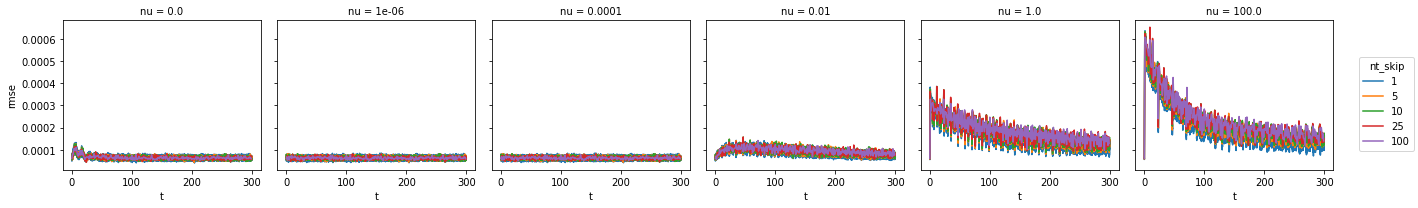

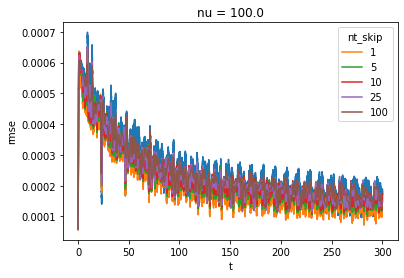

In [9]:
errors_all.rmse.interpolate_na(dim="t").plot(
    hue="nt_skip", col="nu", sharey=True)
plt.show()

# plot the errors w/the prior
fig, ax = plt.subplots()
errors_prior.rmse.isel(nu=[-1]).plot(hue="nu", ax=ax)
errors_all.rmse.isel(nu=[-1]).interpolate_na(dim="t").plot(hue="nt_skip", ax=ax)
plt.show()

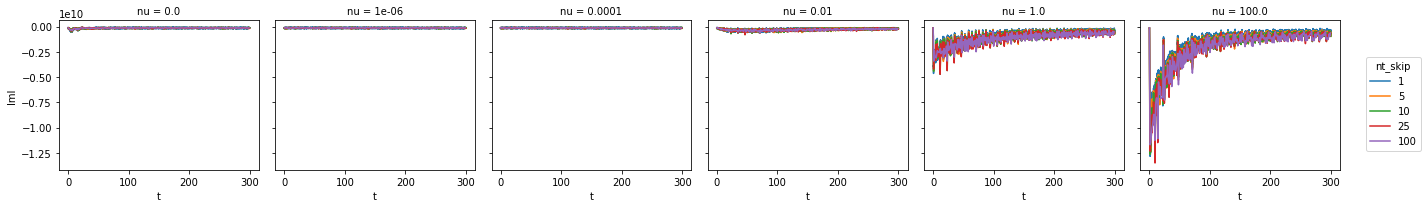

In [10]:
errors_all.lml.interpolate_na(dim="t").plot(
    x="t", hue="nt_skip", col="nu", sharey=True)
plt.show()

And now the same, just with no shared $y$ axis:

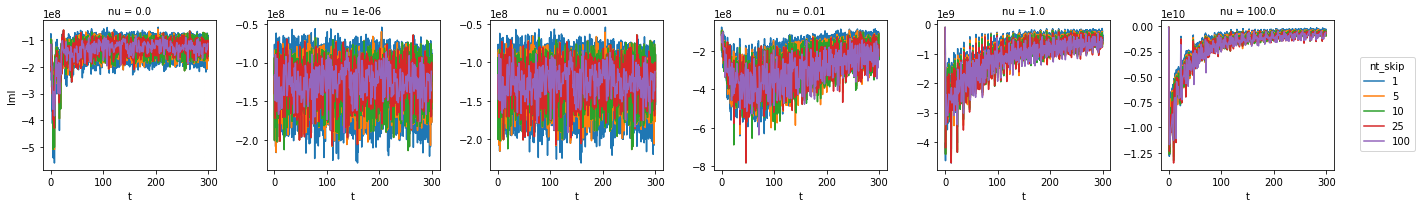

In [11]:
errors_all.lml.interpolate_na(dim="t").plot(
    x="t", hue="nt_skip", col="nu", sharey=False)
plt.show()

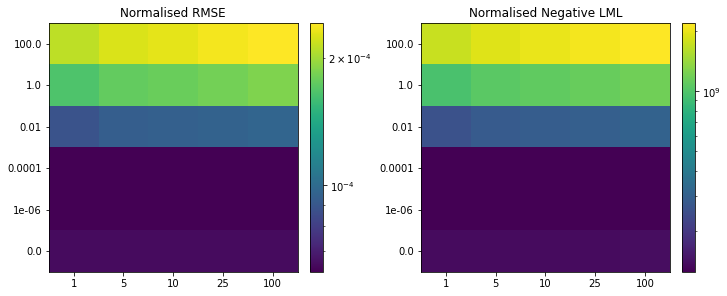

In [12]:
import matplotlib.colors as colors

normalise = True
if normalise:
    total = errors_all.mean(dim="t")
else:
    total = errors_all.sum(dim="t")

rmse_array = total.rmse.to_numpy()
lml_array = -total.lml.to_numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
im = ax[0].pcolormesh(range(len(total.coords["nt_skip"].to_numpy())), 
                      range(len(total.coords["nu"].to_numpy())),
                      rmse_array,
                      norm=colors.LogNorm(vmin=rmse_array.min(), 
                                          vmax=rmse_array.max()))
ax[0].set_xticks(range(len(total.coords["nt_skip"].to_numpy())), 
                 total.coords["nt_skip"].to_numpy())
ax[0].set_yticks(range(len(total.coords["nu"].to_numpy())), 
                 total.coords["nu"].to_numpy())
ax[0].set_title("{s} RMSE".format(s="Normalised" if normalise else ""))
plt.colorbar(im, ax=ax[0])

im = ax[1].pcolormesh(range(len(total.coords["nt_skip"].to_numpy())), 
                      range(len(total.coords["nu"].to_numpy())),
                      lml_array,
                      norm=colors.LogNorm(vmin=lml_array.min(), 
                                          vmax=lml_array.max()))
ax[1].set_xticks(range(len(total.coords["nt_skip"].to_numpy())), 
                 total.coords["nt_skip"].to_numpy())
ax[1].set_yticks(range(len(total.coords["nu"].to_numpy())), 
                 total.coords["nu"].to_numpy())
ax[1].set_title("{s} Negative LML".format(s="Normalised" if normalise else ""))
plt.colorbar(im, ax=ax[1])
plt.show()

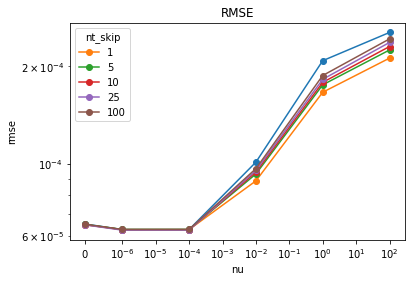

In [13]:
total_prior = errors_prior.mean(dim="t")

fig, ax = plt.subplots()
total_prior.rmse.plot(marker="o", ax=ax, label="Prior")
total.rmse.plot(hue="nt_skip", marker="o", ax=ax)
plt.xscale("symlog", linthresh=1e-6)
plt.yscale("log")
plt.title("RMSE")
plt.show()